In [ ]:
# These are the total libraries we gonna use here
import numpy as np
import pandas as pd
from scipy.stats import uniform 
import scipy.signal as sig
import random
from numpy import random as ran
import decimal
import math
import matplotlib.pyplot as plt
from google.colab import drive
import time
import xlrd
from queue import PriorityQueue

In [ ]:
# For accessing Google Drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
SBSData=[]
for i in range(15):
    valueForExcel = i + 1
    excelFileName = '/content/drive/My Drive/Dataset/SBS' + "{}".format(valueForExcel) + 'Upto200Seconds.xlsx'
    df = pd.read_excel(excelFileName,sheet_name=None)
    # print(df)
    SBSData.append(df)

In [ ]:
SBSData[1]['1sec']
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [ ]:
# Now First we define TSEM class
class TSEM:
  def __init__(self, Amax, A, L0, p, L, wmax, P):
    self.Amax = Amax
    self.A = A
    self.L0 = L0
    self.p = p
    self.L = L
    self.P = P
    self.wmax = wmax
  # AUXILIARY VARIABLE SELECTION
  def AUS(self, V, Z, SBSID, timer):
    if Z[SBSID][timer] == 0:
      return self.Amax[SBSID]
    temp = (V/(Z[SBSID][timer] * math.log(2))) -1
    if temp < 0:
      return 0
    elif temp >= 0 and temp <= self.Amax[SBSID]: 
      # print(temp)
      return int(temp)
    else:
      return self.Amax[SBSID]
  # ADMISSION CONTROL DECISION
  def ACD(self, QD, Z, SBSID, timer):
    temp = getClassObjectSum(QD[SBSID]) - Z[SBSID][timer]
    if temp < 0:
      return True
    else:
      return False
  # TASK ALLOCATION IN MBS
  def TAM(self, alpha, K , g, QM, timer,SBSID):
    temp = alpha*K[timer]*g - getClassObjectSum(QM[SBSID])
    if temp < 0:
      return self.L0/self.p[SBSID]
    else:
      return 0
  # TASK SCHEDULING AND ENERGY MANAGEMENT IN SBS
  def AES(self, QM, QD, QE, K, g, alpha, R, SBSID, timer, m, s, w):
    # total 5 cases
    #Case 1
    if K[timer] == 0:
      # print("case-1.1")
      x =  self.P[SBSID] - QE[SBSID][timer]
      # print(QE[SBSID][timer],'*********************')
      y = x + ((alpha*self.L[SBSID])/self.p[SBSID])
      if timer==1:
        wStar = y
        mStar = R
        sStar = self.L[SBSID]/self.p[SBSID]
        return mStar,wStar,sStar
      if self.wmax[SBSID] <= x: #
        wStar = self.wmax[SBSID]
        mStar = (self.wmax[SBSID]+QE[SBSID][timer])*R/self.P[SBSID]
        sStar = 0
        return mStar,wStar,sStar
      elif self.wmax[SBSID]>x and self.wmax[SBSID]<=y:
        wStar = self.wmax[SBSID]
        mStar = R
        sStar = (self.wmax[SBSID]+QE[SBSID][timer] - self.P[SBSID])/alpha
        return mStar,wStar,sStar
      else:
        wStar = y
        mStar = R
        sStar = self.L[SBSID]/self.p[SBSID]
        return mStar,wStar,sStar
    a = getClassObjectSum(QD[SBSID])/(K[timer]*g*alpha)
    b = (-getClassObjectSum(QM[SBSID]) + getClassObjectSum(QD[SBSID]))*R / (K[timer]*g*self.P[SBSID])
    #case 1
    if a<=1 and b<=1:
      # print("case-1",a,b)
      return 0,0,0
    #case2
    elif b<=1 and a>1:
      # print("case-2")
      mStar = 0
      temp = ((alpha*self.L[SBSID])/self.p[SBSID]) -  QE[SBSID][timer]
      #print(wmax[SBSID],temp)
      if self.wmax[SBSID] <= temp:
        wStar = self.wmax[SBSID]
        sStar = (self.wmax[SBSID]+QE[SBSID][timer])/alpha
        return mStar,wStar,sStar
      else:
        wStar = temp
        sStar = self.L[SBSID]/self.p[SBSID]
        return mStar,wStar,sStar
    #case 3
    elif a<=1 and b>1:
      # print("case-3")
      temp = self.P[SBSID] - QE[SBSID][timer]
      sStar = 0
      if self.wmax[SBSID]<= temp:
        wStar = self.wmax[SBSID]
        mStar = (self.wmax[SBSID]+QE[SBSID][timer])*R/self.P[SBSID]
        return mStar,wStar,sStar
      else :
        wStar = temp
        mStar = R
        return mStar,wStar,sStar
    #case 4
    elif a>1 and a<=b:
      # print("case-4")
      x =  self.P[SBSID] - QE[SBSID][timer]
      y = x + ((alpha*self.L[SBSID])/self.p[SBSID])
      if self.wmax[SBSID]<= x:
        wStar = self.wmax[SBSID]
        mStar = (self.wmax[SBSID]+QE[SBSID][timer])*R/self.P[SBSID]
        sStar = 0
        return mStar,wStar,sStar
      elif self.wmax[SBSID]>x and self.wmax[SBSID]<=y:
        wStar = self.wmax[SBSID]
        mStar = R
        sStar = (self.wmax[SBSID]+QE[SBSID][timer] - self.P[SBSID])/alpha
        return mStar,wStar,sStar
      else:
        wStar = y
        mStar = R
        sStar = self.L[SBSID]/self.p[SBSID]
        return mStar,wStar,sStar
    #case 5
    else:
      # print("case-5")
      x = ((alpha*self.L[SBSID])/self.p[SBSID]) - QE[SBSID][timer]
      y = x + self.P[SBSID]
      if self.wmax[SBSID] <= x:
        wStar = self.wmax[SBSID]
        sStar = (self.wmax[SBSID]+ QE[SBSID][timer])/alpha
        mStar = 0
        return mStar,wStar,sStar
      elif self.wmax[SBSID]>x and self.wmax[SBSID] <= y:
        wStar = self.wmax[SBSID]
        sStar = self.L[SBSID]/self.p[SBSID]
        mStar = (self.wmax[SBSID] - x)*(R/self.P[SBSID])
        return mStar,wStar,sStar
      else:
        wStar = y
        sStar = self.L[SBSID]/self.p[SBSID]
        mStar = R
        return mStar,wStar,sStar

In [ ]:
def initailizeWithZero(temp):
  for _ in range(15):
    temp.append([0,])
def initailizeWithEmpty(temp):
  for _ in range(15):
    temp.append([])

In [ ]:
# Consider there is no restriction in admitted tasks i.e. A(t) = a(t) and all tasks can be computed by SBS
# Consider 15 Sbs and 1 Mbs
# L[i] be the max amount of computation tasks
# p[i] be the max avaliable cpu cycles
# P[i] be transmission power of SBS
L=list(np.random.uniform(8000000000,10000000000,15).astype(int))
p=list(np.random.uniform(1000,1200,15).astype(int)) 
P=list(np.random.uniform(5,15,15).astype(int))
L0 = 10000000000
J = 3500
B = pow(10,6) #10 MHz
sigma = pow(10,-10)
# V = 4 * pow(10,6) #changed from 6
# x = np.random.exponential(scale = 1.0, size = 15) 
alpha = []
for _ in range(15):
  alpha.append(pow(10,-4))

In [ ]:
# Now we define Task class for each device used for knowing arrival and evaluate the Delay
class TaskOfDevice(object):
  def __init__(self,id,numberOfBits):
    self.id = id
    self.numberOfBits = numberOfBits
    self.arrivalTime = float("{0:.3f}".format(time.time()))
    if numberOfBits < 3000 :
      self.priority=5
    elif numberOfBits < 3500 :
      self.priority=4
    elif numberOfBits < 4000 :
      self.priority=3
    elif numberOfBits < 4500 :
      self.priority=2
    else :
      self.priority=1
  
  #Custom Compare Function (less than)
  def __lt__(self, other):
    # # return False
    if self.arrivalTime == other.arrivalTime:
      return self.priority > other.priority
    else :
      return self.arrivalTime > other.arrivalTime
    
  
  #Print each element function
  def __repr__(self):
    return "Datasize "+str(self.numberOfBits)+" ArrivalTime "+str(self.arrivalTime)+" Priority "+str(self.priority)

In [ ]:
# Now we define Task class for each device used for knowing arrival and evaluate the Delay
class TaskOfDeviceFCFS(object):
  def __init__(self,id,numberOfBits):
    self.id = id
    self.numberOfBits = numberOfBits
    self.arrivalTime = float("{0:.3f}".format(time.time()))
    if numberOfBits < 3000 :
      self.priority=5
    elif numberOfBits < 3500 :
      self.priority=4
    elif numberOfBits < 4000 :
      self.priority=3
    elif numberOfBits < 4500 :
      self.priority=2
    else :
      self.priority=1
  
  #Custom Compare Function (less than)
  def __lt__(self, other):
    return self.arrivalTime > other.arrivalTime
    
  
  #Print each element function
  def __repr__(self):
    return "Datasize "+str(self.numberOfBits)+" ArrivalTime "+str(self.arrivalTime)+" Priority "+str(self.priority)

In [ ]:
# Declare Total number of seconds that we want to compute
numberOfSeconds = 500
utilList=[]
totalDelay=0.0
totalDevices=0
totalCostInINR=0.0;
totalEnergySaved=0;

def getClassObjectSum(lst):
  sum = 0
  if len(lst) == 0:
    return 0
  for i in range(len(lst)):
    tempClassObject = lst[i]
    sum += tempClassObject.numberOfBits
  return sum

In [ ]:
def queryTSEM(v,position, queueType):
  # working one
  # For t = 0 sec
  global totalDelay
  global totalDevices
  global totalEnergySaved
  global totalCostInINR
  totalDelay=0.0
  totalDevices=0
  totalCostInINR=0.0;
  totalEnergySaved=0;
  queuelength = [] #queuelength every second 
  QD = [] # Task Queue of SBS
  QM = [] # Task Queue of MBS
  Z = [] # Virtual Queue
  K = [] # Virtual Queue
  w = [] # Purchased Grid Energy
  e = [] # Harvested Energy
  El = [] # Energy consumption by processing Computational tasks
  Em = [] # Energy consumption by Data Transmission
  QE = [] # Available Energy in battery of SBS
  H = [] # Channel Power Gain from SBS to MBS
  R = [] # Maximum achievable transmission rate of SBS i

  # For t = 0 sec above all will be zero
  initailizeWithZero(queuelength)
  initailizeWithZero(Z)
  # initailizeWithZero(H)
  # initailizeWithZero(R)
  initailizeWithZero(e)
  initailizeWithZero(w)
  initailizeWithZero(El)
  initailizeWithZero(Em)
  initailizeWithZero(QE)


  x = [] # Processed Computations Tasks in MBS
  s = [] # Processed Computations Tasks in SBS
  m = [] # Transferred Computations Tasks in SBS
  a = [] # Admitted Tasks in SBS
  initailizeWithEmpty(x)
  initailizeWithEmpty(s)
  initailizeWithEmpty(a)
  initailizeWithEmpty(m)
  initailizeWithEmpty(QD)
  initailizeWithEmpty(QM)
  initailizeWithEmpty(H)
  initailizeWithEmpty(R)

  # Let us Assume Tasks are arrived at t = 0 sec
  # So the QD for next sec changes
  # QM wont change as there wont be any tasks transmitted from SBS to MSB at t = 0 sec
  # Lets Build the QD
  # Now Lets Create Arrival Tasks with Random Bits
  # Now we will read the excel sheet for every Sbs
  # totalDelay = 0.0
  # totalDevices = 0

 
  PriorityQueueList=[]
  for i in range(15):
    pq=PriorityQueue()
    PriorityQueueList.append(pq)
 
  # As Energy required for the Admitted Tasks is negligible QE, Z, K will be 0 for the first second as well
  for i in range(15):
    QE[i].append(0)
    Z[i].append(0)
    x[i].append(0)
    s[i].append(0)
  K.append(0)
  K.append(0)
  # lets declare the other varaibles also
  u = []
  initailizeWithZero(u)
  #Declare Amax
  h = []
  r = []
  Amax = []
  wmax = []
  for _ in range(15):
    Amax.append(0)
    wmax.append(0)
  #Iterating 1000s for finding the utility
  for timer in range(0, numberOfSeconds):
    print(timer)
    # Now Lets Create Arrival Tasks with Random Bits
    
    for SBSID in range(15):
      valueForExcel = SBSID + 1
      # excelFileName = '/content/drive/My Drive/Dataset/SBS' + "{}".format(valueForExcel) + 'Upto200Seconds.xlsx'
      # df = pd.read_excel(excelFileName, sheet_name = timer) # commented
      df=SBSData[SBSID]["{}".format((timer)%199+1) + "sec"]
      pq=PriorityQueueList[SBSID]
      for everyTask in range(len(df)):
        if queueType == True:
          tempClassObject = TaskOfDevice(df['DevicaName'][everyTask],df['ComputionTasksInBits'][everyTask])
        else:
          tempClassObject = TaskOfDeviceFCFS(df['DevicaName'][everyTask],df['ComputionTasksInBits'][everyTask])
        pq.put(tempClassObject)
      tsem = TSEM(Amax,df,L0,p,L,wmax,P)
      
      # Tells wheather to admit tasks or not
      tempList = []
      arrivalTasksSum = 0

      while not pq.empty():
        tempClassObject = pq.get()
        arrivalTasksSum += tempClassObject.numberOfBits 
        tempList.append(tempClassObject)
      # a[SBSID].append(arrivalTasksSum)
      # QD[SBSID]+= tempList
      # queuelength[SBSID].append(getClassObjectSum(QD[SBSID])) __________________________________________________________________________
      H[SBSID].append(np.random.exponential(scale = 1.0))
      #Now we calculate r
      temp = B * (math.log((1+((P[SBSID]*H[SBSID][timer])/(B*sigma))),2))
      # print(timer,temp,H[SBSID][timer],"&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&");
      R[SBSID].append(temp)
      Amax[SBSID] = max(Amax[SBSID],arrivalTasksSum)
      # print(np.sum(tempList))
      # print(Amax[SBSID])
      # flag_1 = tsem.ACD(QD, Z, SBSID, timer)
      # if flag_1 == True:
      #   a[SBSID].append(np.sum(tempList))
      #   QD[SBSID]+=tempList #changed
      # else:
      #   a[SBSID].append(0)
      V= v* pow(10,6)
      u[SBSID].append(tsem.AUS(V, Z, SBSID, timer))
      xStar = tsem.TAM(alpha[SBSID], K, 3, QM, timer, SBSID)
      mStar,wStar,sStar = tsem.AES(QM, QD, QE, K, 3, alpha[SBSID], R[SBSID][timer], SBSID, timer, m, s, w)
      # print(mStar,wStar,sStar,np.sum(tempList)) 
      # print(wStar)
      wmax[SBSID] = max(wmax[SBSID], wStar)
      # print("+++++++++++++++++++",wStar)
      w[SBSID].append(max(wStar,0.0))
      # print(timer,w[SBSID][timer],"@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
      # if(wStar < 0):
      #   print(wStar)
      # For evaluating the tasks individually
      sum1=0
      sum2=0
      # for num in range(len(QD[SBSID])):
      # queuelength[SBSID].append(len(QD[SBSID]))
      
      #Done Upto Here

      while QD[SBSID]:
        if sum1 + QD[SBSID][0].numberOfBits <= sStar :
          totalDelay += float("{0:.3f}".format( float("{0:.3f}".format(time.time())) - QD[SBSID][0].arrivalTime ))
          sum1 += QD[SBSID][0].numberOfBits
          totalDevices += 1
        elif sum2 + QD[SBSID][0].numberOfBits <= mStar:
          sum2 += QD[SBSID][0].numberOfBits
          m[SBSID].append(QD[SBSID][0])
        else:
          break
        QD[SBSID].pop(0) 


      flag_1 = tsem.ACD(QD, Z, SBSID, timer) # changed
      # print(flag_1)
      if flag_1 == True :
        a[SBSID].append(getClassObjectSum(tempList))
        QD[SBSID]+=tempList #changed
      else:
        a[SBSID].append(0)
        
      queuelength[SBSID].append(getClassObjectSum(QD[SBSID])) # changed for sum
      sum3=0
      while QM[SBSID]:
        if sum3 + QM[SBSID][0].numberOfBits <= xStar :
          totalDelay += float("{0:.3f}".format( float("{0:.3f}".format(time.time())) - QM[SBSID][0].arrivalTime ))
          sum3 += QM[SBSID][0].numberOfBits
          totalDevices += 1
        else:
          break
        QM[SBSID].pop(0)
      if len(m[SBSID]) > 0:
        QM[SBSID]+=m[SBSID]
      e[SBSID].append(np.random.uniform(0,200))
      s[SBSID].append(sum1)
      # print(SBSID,sum1,sum2,len(QM[SBSID]),sum3)
      # print(len(QD[SBSID]))
      x[SBSID].append(sum3)
      Z[SBSID].append(max(Z[SBSID][timer] + u[SBSID][timer] - a[SBSID][timer],0))
      QE[SBSID].append(QE[SBSID][timer] + e[SBSID][timer] + w[SBSID][timer] - (alpha[SBSID]*sum1) - ((P[SBSID]*sum2)/R[SBSID][timer]))
    temp=0
    for SBSID in range(15):
      temp =  temp + 3*(w[SBSID][timer] + (alpha[SBSID] * x[SBSID][timer]))
    K.append(max(K[timer]+temp-J,0))
    totalEnergySaved=totalEnergySaved+max((15*J)-temp,0);
    m=[]
    initailizeWithEmpty(m)
  t = []
  t = [i for i in range(0,numberOfSeconds+1)]
  xAxis = []
  xAxis = [0,]
  for x in t[1:]:
    sum = 0
    for i in range(15):
      temp = np.sum(a[i][:x])/x
      sum += math.log(1+temp)
    xAxis.append(sum)
  plt.plot(t, xAxis)
  
  # plt.ylim(232.5,242.5)
  plt.xlim(1)
  plt.xlabel('time')
  plt.ylabel('System utility')
  plt.title('Utility vs time')
  # plt.xlim(0,500)
  # set the spacing between subplots
  # fig.tight_layout()
  plt.margins(x=0.01)
  t = [i for i in range(0,numberOfSeconds+1)] 
  xAxis2 = [] 
  for x in t[1:]: 
    sum = 0
    for i in range(15):
      sum += np.sum(queuelength[i][x])
      # sum += np.sum(QD[SBSID])
    sum = sum/15
    xAxis2.append(sum)
  return xAxis,xAxis2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

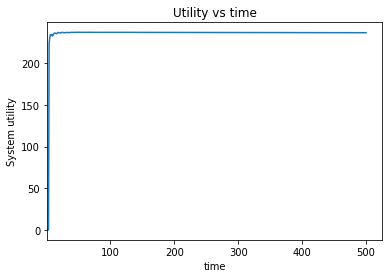

In [ ]:
utility = []
qLens=[]
util,qLen =queryTSEM(2,1,True)
print(totalDelay)
print(totalDevices)
print('Total average Delay per task is : ',totalDelay/totalDevices)
print(totalEnergySaved)
totalCostInINR=(totalEnergySaved/1200000.0)
print(totalCostInINR)
# util1,qLen1=queryTSEM(2,1,False)
utility.append(util)
plt.show()

In [ ]:
print(sum(util)/(len(util)-4))

237.0357298958655


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

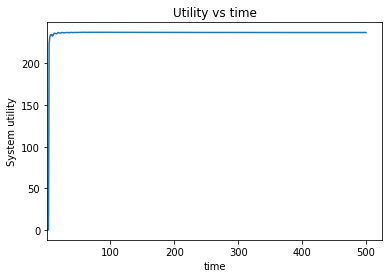

In [ ]:
utility = []
qLens=[]
util,qLen =queryTSEM(2,1,False)
print(totalDelay)
print(totalDevices)
print('Total average Delay per task is : ',totalDelay/totalDevices)
print(totalEnergySaved)
totalCostInINR=(totalEnergySaved/1200000.0)
print(totalCostInINR)
utility.append(util)
plt.show()

In [ ]:
print(sum(util)/(len(util)-4))

237.21342562895845


In [ ]:
util

[0,
 0.0,
 0.0,
 0.0,
 224.03135751768548,
 231.09063696998302,
 234.4350369114424,
 234.41441422365065,
 234.678681341577,
 232.91193611254707,
 233.7512065778253,
 235.17959694921987,
 236.2758324581117,
 236.34159643602632,
 236.24772553295028,
 235.74077660070412,
 235.83145814099183,
 236.5383369593536,
 237.14165722366062,
 237.05057963557215,
 236.7876891714861,
 236.5763557982423,
 236.52365489298913,
 236.92552418613633,
 237.28149592209581,
 237.14958810432503,
 237.01683103181296,
 236.8292805793674,
 236.84500991648014,
 236.85387847533093,
 237.1459164893909,
 237.1979364796294,
 237.2974780828739,
 237.13921701518376,
 237.04191250386137,
 237.0469339575148,
 237.0937882681746,
 237.2739728267302,
 237.39863201485778,
 237.26898506263544,
 237.1421478674417,
 237.18296785805774,
 237.2615496688041,
 237.2972617984026,
 237.36485716808608,
 237.28827851728465,
 237.32088329445529,
 237.24691993633175,
 237.24586064087188,
 237.27600998740064,
 237.33566953020866,
 237.3621

In [ ]:
t = [i for i in range(1,numberOfSeconds+1)]
len(t)
print(t)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
len(qLen)

500

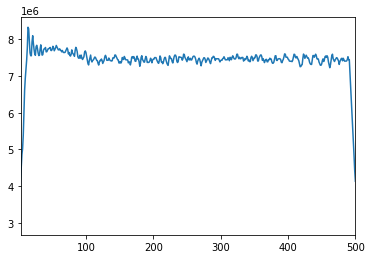

In [ ]:
# plt.ylim(600000,20000000)
plt.xlim(3,numberOfSeconds)
plt.plot(t,smooth(qLen,20))
